### IS backtest

#### Data Preprocessing

In [1]:
import os
import random
import requests
import numpy as np
import pandas as pd
from tqdm import tqdm
import lunardate

from datetime import datetime,timedelta, timezone

In [234]:
def get_vn30f1m_trading(start, ticker):
    """
    Fetch VN30F1M trading data from the API.

    Parameters:
    start (int): The start timestamp.
    ticker (str): The ticker symbol.

    Returns:
    pd.DataFrame: A DataFrame containing the trading data.
    """
    end = '9999999999'
    url = f"https://services.entrade.com.vn/chart-api/chart?from={start}&resolution=1&symbol={ticker}&to={end}"
    try:
        resp = requests.get(url)
        data = resp.json()
        if not data:
            print(f"No data returned for {ticker}")
        vn30f1m = pd.DataFrame(data).iloc[:, :6]
        vn30f1m['t'] = vn30f1m['t'].astype(int).apply(lambda x: (datetime.fromtimestamp(x, timezone.utc) + timedelta(hours=7)).replace(tzinfo=None))
        vn30f1m.columns = ['date', 'open', 'high', 'low', 'close', 'volume']
        return vn30f1m
    except Exception as e:
        print(f"Error fetching data for {ticker}: {e}.")
        return pd.DataFrame()

df = get_vn30f1m_trading('0', 'VN30F1M')
df

,date,open,high,low,close,volume
0,2018-08-13 09:00:00,943.5,943.5,942.9,942.9,975
1,2018-08-13 09:01:00,943.0,943.1,942.9,943.1,220
2,2018-08-13 09:02:00,943.0,943.6,943.0,943.5,121
3,2018-08-13 09:03:00,943.3,943.4,943.3,943.4,135
4,2018-08-13 09:04:00,943.2,943.2,943.0,943.1,361
...,...,...,...,...,...,...
333251,2024-08-16 10:15:00,1272.7,1273.3,1272.6,1273.0,2934
333252,2024-08-16 10:16:00,1272.8,1273.7,1272.8,1273.2,1894
333253,2024-08-16 10:17:00,1273.1,1273.2,1272.8,1273.0,1259
333254,2024-08-16 10:18:00,1273.0,1273.3,1272.8,1273.0,1015


In [235]:
df['date'] = pd.to_datetime(df['date'])

morning_start = pd.to_datetime('09:00:00').time()
morning_end = pd.to_datetime('11:30:00').time()
afternoon_start = pd.to_datetime('13:00:00').time()
afternoon_end = pd.to_datetime('14:30:00').time()
extra_time = pd.to_datetime('14:45:00').time()

In [236]:
def get_vietnam_trading_days(start_date, end_date):
    # Tạo danh sách các ngày trong khoảng thời gian
    date_range = pd.date_range(start_date, end_date)

    # Loại bỏ các ngày cuối tuần (Thứ 7, Chủ nhật)
    trading_days = date_range[date_range.weekday < 5]

    # Lấy các năm trong khoảng thời gian
    years = list(set(date_range.year))

    all_holidays = []

    for year in years:
        # Danh sách các ngày lễ (dạng datetime)
        holidays = [
            datetime(year, 1, 1),  # Tết Dương lịch
            datetime(year, 4, 30),  # Ngày Giải phóng miền Nam
            datetime(year, 5, 1),  # Ngày Quốc tế Lao động
            datetime(year, 9, 2)  # Ngày Quốc khánh
        ]

        # Tính ngày Tết Nguyên Đán
        lunar_new_year = lunardate.LunarDate(year, 1, 1).toSolarDate()
        tet_holidays = [lunar_new_year + timedelta(days=i) for i in range(7)]  # Tết Nguyên Đán kéo dài 7 ngày
        holidays.extend(tet_holidays)

        # Tính ngày Giỗ tổ Hùng Vương (10 tháng 3 âm lịch)
        hung_vuong_anniversary = lunardate.LunarDate(year, 3, 10).toSolarDate()
        holidays.append(hung_vuong_anniversary)

        # Thêm các ngày lễ vào danh sách tổng
        all_holidays.extend(holidays)

    # Loại bỏ các ngày lễ khỏi danh sách ngày giao dịch
    trading_days = [day for day in trading_days if day not in all_holidays]

    return trading_days

In [237]:
def generate_trading_times(day):
    times = []
    current_time = pd.Timestamp.combine(day, morning_start)
    end_time = pd.Timestamp.combine(day, morning_end)
    while current_time <= end_time:
        times.append(current_time)
        current_time += pd.Timedelta(minutes=1)
        
    current_time = pd.Timestamp.combine(day, afternoon_start)
    end_time = pd.Timestamp.combine(day, afternoon_end)
    while current_time <= end_time:
        times.append(current_time)
        current_time += pd.Timedelta(minutes=1)
        
    times.append(pd.Timestamp.combine(day, extra_time))
    
    return times

In [238]:
start_date = df['date'].min().date()
end_date = df['date'].max().date()
trading_days = get_vietnam_trading_days(start_date, end_date)

full_range = []
for day in trading_days:
    full_range.extend(generate_trading_times(day))

In [239]:
full_range = pd.DatetimeIndex(full_range)
df.set_index('date', inplace=True)
missing_times = full_range.difference(df.index)
print(f"Missing timestamps: {missing_times}")

Missing timestamps: DatetimeIndex(['2018-08-13 14:45:00', '2018-08-28 09:26:00',
               '2018-08-28 09:29:00', '2018-08-28 09:51:00',
               '2018-08-29 10:00:00', '2018-09-03 09:00:00',
               '2018-09-03 09:01:00', '2018-09-03 09:02:00',
               '2018-09-03 09:03:00', '2018-09-03 09:04:00',
               ...
               '2024-08-16 14:22:00', '2024-08-16 14:23:00',
               '2024-08-16 14:24:00', '2024-08-16 14:25:00',
               '2024-08-16 14:26:00', '2024-08-16 14:27:00',
               '2024-08-16 14:28:00', '2024-08-16 14:29:00',
               '2024-08-16 14:30:00', '2024-08-16 14:45:00'],
              dtype='datetime64[ns]', length=44367, freq=None)


In [240]:
df_reindexed = df.reindex(full_range)
df = df_reindexed.ffill()
df.index.name = 'date'
df.reset_index(inplace=True)
df

,date,open,high,low,close,volume
0,2018-08-13 09:00:00,943.5,943.5,942.9,942.9,975.0
1,2018-08-13 09:01:00,943.0,943.1,942.9,943.1,220.0
2,2018-08-13 09:02:00,943.0,943.6,943.0,943.5,121.0
3,2018-08-13 09:03:00,943.3,943.4,943.3,943.4,135.0
4,2018-08-13 09:04:00,943.2,943.2,943.0,943.1,361.0
...,...,...,...,...,...,...
377617,2024-08-16 14:27:00,1272.8,1273.6,1272.8,1273.5,1482.0
377618,2024-08-16 14:28:00,1272.8,1273.6,1272.8,1273.5,1482.0
377619,2024-08-16 14:29:00,1272.8,1273.6,1272.8,1273.5,1482.0
377620,2024-08-16 14:30:00,1272.8,1273.6,1272.8,1273.5,1482.0


#### Extract only VN30F1M close price at 14pm

In [793]:
vn30f1m = df.copy()
vn30f1m['date'] = pd.to_datetime(vn30f1m['date'])
vn30f1m = vn30f1m[vn30f1m['date'].dt.time == pd.to_datetime('14:00:00').time()]
vn30f1m = vn30f1m[['date', 'close']]
vn30f1m.set_index('date', inplace=True)
vn30f1m.index = vn30f1m.index.date
vn30f1m.index.name = 'date'
vn30f1m.dropna(inplace=True)
vn30f1m

,close
date,
2018-08-13,948.9
2018-08-14,959.1
2018-08-15,958.6
2018-08-16,943.1
2018-08-17,946.8
...,...
2024-08-12,1264.7
2024-08-13,1266.6
2024-08-14,1271.1


#### IS-OS split

In [794]:
vn30f1m_train = vn30f1m.iloc[:-756]
vn30f1m_test = vn30f1m.iloc[-756:]

#### Scraping HSI price data

In [760]:
import yfinance as yf
import pytz

ticker_list = ['^HSI']

ticker_intraday_prices = pd.DataFrame()
ticker_intraday_prices = {}

item = ticker_list[0]
print(f"Downloading data for: {item}")

download_data = yf.download(tickers=item, start='2018-08-13', end=datetime.now().strftime('%Y-%m-%d'))
download_data.index = pd.to_datetime(download_data.index)
download_data = download_data.reindex(vn30f1m.index)
download_data = download_data.ffill()

ticker_intraday_prices[item] = download_data

print(ticker_intraday_prices[item])
print(ticker_intraday_prices[item].shape)

[*********************100%%**********************]  1 of 1 completed

                    Open          High           Low         Close  \
date                                                                 
2018-08-13  27956.779297  28085.169922  27823.210938  27936.570312   
2018-08-14  27938.320312  27946.550781  27522.820312  27752.929688   
2018-08-15  27724.720703  27727.269531  27249.080078  27323.589844   
2018-08-16  26871.109375  27405.250000  26871.109375  27100.060547   
2018-08-17  27388.570312  27450.839844  27101.099609  27213.410156   
...                  ...           ...           ...           ...   
2024-08-12  17102.980469  17162.759766  17002.929688  17111.650391   
2024-08-13  17160.210938  17252.880859  17074.689453  17174.060547   
2024-08-14  17233.679688  17254.230469  17055.699219  17113.359375   
2024-08-15  17233.679688  17254.230469  17055.699219  17113.359375   
2024-08-16  17233.679688  17254.230469  17055.699219  17113.359375   

               Adj Close        Volume  
date                                    
2018-08

#### Extract HSI index close price 4pm (UTC)

In [795]:
hsi = ticker_intraday_prices[item]
hsi = hsi[['Close']]
hsi_train = hsi.iloc[:-756]
hsi_test = hsi.iloc[-756:]

#### Merge VN30F1M and HSI index price into one DataFrame

In [810]:
prices = pd.merge(vn30f1m_train, hsi_train, left_index=True, right_index=True, how = 'inner')
prices.rename(columns={'close': 'VN30F1M', 'Close': 'HSI'}, inplace=True)
prices.index.name = 'Date'
prices

,VN30F1M,HSI
Date,,
2018-08-13,948.9,27936.570312
2018-08-14,959.1,27752.929688
2018-08-15,958.6,27323.589844
2018-08-16,943.1,27100.060547
2018-08-17,946.8,27213.410156
...,...,...
2021-09-10,1450.8,26205.910156
2021-09-13,1439.6,25813.810547
2021-09-14,1436.5,25502.230469


#### Trading hypothesis
- Yesterday's price of HSI > The day before yesterday's price of HSI, enter long position for VN30F1m

- Yesterday's price of HSI < The day before yesterday's price of HSI, enter short position for VN30F1m

- Else: do nothing (no position opened/close position)

#### T-test ANOVA

- Null Hypothesis (H₀): There is no difference between the means of VN30F1M and HSI

- Alternative Hypothesis (H₁): There is a difference between the means of VN30F1M and HSI

Interpretation:

- If the p-value < 0.05, it rejects the null hypothesis. In other words, it indicates that the difference between the means of VN30F1M and HSI is statistically significant.

- If the p-value >= 0.05, you would fail to reject the null hypothesis, indicating that there is no significant difference between the means of VN30F1M and HSI.

In [375]:
from scipy.stats import ttest_ind

t_statistic, p_value = ttest_ind(prices['VN30F1M'], prices['HSI'])

print(f"T-statistic: {t_statistic}")
print(f"P-value: {p_value}")

T-statistic: -407.62238741640266
P-value: 0.0


- There is a statistically significant difference between the mean values of VN30F1M and HSI.

- The VN30F1M and HSI series are not likely to have the same mean values

#### Correlation

By computing rolling correlations, we can observe how the relationship between **VN30F1M** and **HSI** changes over time. This can reveal patterns such as periods of high correlation (when they move closely together) or low correlation (when their movements diverge).

In [376]:
window_size = 30
results = []

for i in range(len(prices) - window_size + 1):
    window = prices.iloc[i:i + window_size]
    correlation_coef = window['VN30F1M'].corr(window['HSI'])
    results.append(correlation_coef)

results = pd.DataFrame(results, columns=['Rolling Correlation'])
print(results)

     Rolling Correlation
0               0.628661
1               0.603310
2               0.559129
3               0.553148
4               0.531675
..                   ...
764             0.418256
765             0.422786
766             0.437963
767             0.434394
768             0.391457

[769 rows x 1 columns]


In [377]:
(results > 0).sum()

Rolling Correlation    583
dtype: int64

In [378]:
(results < 0).sum()

Rolling Correlation    186
dtype: int64

We have 1033 positive correlations and 318 negative correlations, the positive correlations do outnumber the negative correlations. This suggests that, overall, the assets tend to move ***in the same direction more frequently than in opposite directions***.

#### Trading strategy

In [811]:
def momentum_hsi(df, lookback_period=0):
    positions = []

    for i in range(lookback_period+1, len(df)):
        if df['HSI'].iloc[i - lookback_period] > df['HSI'].iloc[i - (lookback_period+1)]:
            positions.append(1)
        elif df['HSI'].iloc[i - lookback_period] < df['HSI'].iloc[i - (lookback_period+1)]:
            positions.append(-1)
        else:
            positions.append(0)
    
    positions.insert(0, 0)
    df['Pos'] = positions
    return df

- If the current day's price is higher than the previous day's price, it suggests upward momentum, and the function appends 1 to the positions list.

- If the current day's price is lower than or equal to the previous day's price, it suggests downward or neutral momentum, and the function appends -1 to the positions list.

In [847]:
def set_entry_time(row):
    if row['Pos'] != 0:
        return pd.to_datetime(row.name).replace(hour=14, minute=00)
    return None

def is_third_thursday(date):
    date = pd.to_datetime(date)
    if date.weekday() != 3:
        return False
    first_day = date.replace(day=1)
    first_thursday = first_day + pd.DateOffset(days=(3 - first_day.weekday() + 7) % 7)
    third_thursday = first_thursday + pd.DateOffset(weeks=2)
    return date == third_thursday

def get_end_of_day_price(date, df):
    end_of_day_time = pd.to_datetime(date).replace(hour=14, minute=45)
    end_of_day_data = df[df['date'] == end_of_day_time]
    if not end_of_day_data.empty:
        return end_of_day_data['close'].values[0]
    else:
        return None
    
def check_exit_condition(row, df, stop_loss=0.007, take_profit=0.007):
    df['date'] = pd.to_datetime(df['date'])
    
    exit_time = None
    exit_price = None
    entry_time = row['entry_time']
    
    if pd.notna(entry_time):
        entry_price = df.loc[df['date'] == entry_time, 'close'].values[0]
        print(f"Entry Time: {entry_time}, Entry Price: {entry_price}")
    else:
        print(f"Missing entry time. Cannot retrieve entry price.")
        return None, None
    
    end_time = pd.to_datetime(row.name).replace(hour=14, minute=30)
 
    relevant_prices = df[(df['date'] > entry_time) & (df['date'] <= end_time)]
    
    stop_loss_long = entry_price * (1 - stop_loss)
    stop_loss_short = entry_price * (1 + stop_loss)
    take_profit_long = entry_price * (1 + take_profit)
    take_profit_short = entry_price * (1 - take_profit)
    print(f"Stop Loss (Long): {stop_loss_long}, Stop Loss (Short): {stop_loss_short}")
    print(f"Take Profit (Long): {take_profit_long}, Take Profit (Short): {take_profit_short}")

    if row['is_third_thursday'] and row['Pos'] != 0:
        if row['Pos'] == 1:  # Long position
            for _, price_row in relevant_prices.iterrows():
                if price_row['close'] < stop_loss_long:  # Stop loss triggered
                    exit_time = price_row['date']
                    exit_price = price_row['close']
                    print(f"Long position stop loss triggered at {exit_time} with price {exit_price}")
                    return exit_time, exit_price
                if price_row['close'] > take_profit_long:  # Take profit triggered
                    exit_time = price_row['date']
                    exit_price = price_row['close']
                    print(f"Long position take profit triggered at {exit_time} with price {exit_price}")
                    return exit_time, exit_price

        elif row['Pos'] == -1:  # Short position
            for _, price_row in relevant_prices.iterrows():
                if price_row['close'] > stop_loss_short:  # Stop loss triggered
                    exit_time = price_row['date']
                    exit_price = price_row['close']
                    print(f"Short position stop loss triggered at {exit_time} with price {exit_price}")
                    return exit_time, exit_price
                if price_row['close'] < take_profit_short:  # Take profit triggered
                    exit_time = price_row['date']
                    exit_price = price_row['close']
                    print(f"Short position take profit triggered at {exit_time} with price {exit_price}")
                    return exit_time, exit_price
        
        end_time = pd.to_datetime(row.name).replace(hour=14, minute=45)
        exit_price = df.loc[df['date'] == end_time, 'close'].values[0] if not df[df['date'] == end_time].empty else None
        print(f"Exit condition due to third Thursday: Exit Time: {end_time}, Exit Price: {exit_price}, Entry Price: {entry_price}")
        return end_time, exit_price

    if pd.isna(entry_time) or pd.isna(row['Pos']) or row['Pos'] == 0:
        print(f"No entry time, position, or already exited: Entry Time: {entry_time}, Position: {row['Pos']}")
        return None, None

    end_time = entry_time.replace(hour=14, minute=30)
    
    relevant_prices = df[(df['date'] > entry_time) & (df['date'] <= end_time)]
    
    if row['Pos'] == 1:  # Long position
        for _, price_row in relevant_prices.iterrows():
            print(f"Checking long position: {price_row['date']}, Price: {price_row['close']}")
            if price_row['close'] < stop_loss_long:  # Stop loss triggered
                exit_time = price_row['date']
                exit_price = price_row['close']
                print(f"Long position stop loss triggered at {exit_time} with price {exit_price}")
                break
            if price_row['close'] > take_profit_long:  # Take profit triggered
                exit_time = price_row['date']
                exit_price = price_row['close']
                print(f"Long position take profit triggered at {exit_time} with price {exit_price}")
                break

    elif row['Pos'] == -1:  # Short position
        for _, price_row in relevant_prices.iterrows():
            print(f"Checking short position: {price_row['date']}, Price: {price_row['close']}")
            if price_row['close'] > stop_loss_short:  # Stop loss triggered
                exit_time = price_row['date']
                exit_price = price_row['close']
                print(f"Short position stop loss triggered at {exit_time} with price {exit_price}")
                break
            if price_row['close'] < take_profit_short:  # Take profit triggered
                exit_time = price_row['date']
                exit_price = price_row['close']
                print(f"Short position take profit triggered at {exit_time} with price {exit_price}")
                break
    
    return exit_time, exit_price



In [848]:
prices = momentum_hsi(prices)
prices['is_third_thursday'] = prices.index.map(is_third_thursday)
prices['entry_time'] = prices.apply(set_entry_time, axis=1)
prices[['exit_time', 'exit_price']] = prices.apply(lambda row: check_exit_condition(row, df), axis=1, result_type='expand')
prices

Missing entry time. Cannot retrieve entry price.
Entry Time: 2021-09-20 14:00:00, Entry Price: 1461.5
Stop Loss (Long): 1451.2694999999999, Stop Loss (Short): 1471.7305
Take Profit (Long): 1471.7305, Take Profit (Short): 1451.2694999999999
Checking short position: 2021-09-20 14:01:00, Price: 1461.8
Checking short position: 2021-09-20 14:02:00, Price: 1459.3
Checking short position: 2021-09-20 14:03:00, Price: 1458.0
Checking short position: 2021-09-20 14:04:00, Price: 1458.4
Checking short position: 2021-09-20 14:05:00, Price: 1456.8
Checking short position: 2021-09-20 14:06:00, Price: 1458.0
Checking short position: 2021-09-20 14:07:00, Price: 1457.2
Checking short position: 2021-09-20 14:08:00, Price: 1457.0
Checking short position: 2021-09-20 14:09:00, Price: 1456.7
Checking short position: 2021-09-20 14:10:00, Price: 1456.9
Checking short position: 2021-09-20 14:11:00, Price: 1456.0
Checking short position: 2021-09-20 14:12:00, Price: 1455.2
Checking short position: 2021-09-20 14:1

,VN30F1M,HSI,Pos,is_third_thursday,entry_time,exit_time,exit_price,pnl
date,,,,,,,,
2021-09-17,1456.5,24920.759766,0,False,NaT,NaT,NaN,0.0
2021-09-20,1461.5,24099.140625,-1,False,2021-09-20 14:00:00,NaT,NaN,NaN
2021-09-21,1439.6,24221.539062,1,False,2021-09-21 14:00:00,NaT,NaN,NaN
2021-09-22,1440.8,24221.539062,0,False,NaT,NaT,NaN,NaN
2021-09-23,1453.8,24510.980469,1,False,2021-09-23 14:00:00,NaT,NaN,NaN
...,...,...,...,...,...,...,...,...
2024-08-12,1264.7,17111.650391,1,False,2024-08-12 14:00:00,NaT,NaN,NaN
2024-08-13,1266.6,17174.060547,1,False,2024-08-13 14:00:00,NaT,NaN,NaN
2024-08-14,1271.1,17113.359375,-1,False,2024-08-14 14:00:00,NaT,NaN,NaN


In [849]:
prices['exit_time'].values

array([                          'NaT',                           'NaT',
                                 'NaT',                           'NaT',
                                 'NaT',                           'NaT',
                                 'NaT', '2021-09-28T14:24:00.000000000',
                                 'NaT',                           'NaT',
                                 'NaT',                           'NaT',
                                 'NaT',                           'NaT',
                                 'NaT', '2021-10-08T14:15:00.000000000',
       '2021-10-11T14:23:00.000000000',                           'NaT',
                                 'NaT',                           'NaT',
                                 'NaT', '2021-10-18T14:24:00.000000000',
                                 'NaT', '2021-10-20T14:15:00.000000000',
       '2021-10-21T14:45:00.000000000',                           'NaT',
                                 'NaT', '2021-10-26

#### Vectorized PnL Backtest

In [850]:
def pnl(df):
    df['pnl'] = np.nan
    
    df['pnl'] = np.where(
        pd.notna(df['exit_price']),
        (df['exit_price'] - df['VN30F1M']) * df['Pos'] * 23000000,
        np.nan
    )
    
    if not df.empty:
        df.at[df.index[0], 'pnl'] = 0
    
    return df

In [851]:
prices = pnl(prices)
prices

,VN30F1M,HSI,Pos,is_third_thursday,entry_time,exit_time,exit_price,pnl
date,,,,,,,,
2021-09-17,1456.5,24920.759766,0,False,NaT,NaT,NaN,0.0
2021-09-20,1461.5,24099.140625,-1,False,2021-09-20 14:00:00,NaT,NaN,NaN
2021-09-21,1439.6,24221.539062,1,False,2021-09-21 14:00:00,NaT,NaN,NaN
2021-09-22,1440.8,24221.539062,0,False,NaT,NaT,NaN,NaN
2021-09-23,1453.8,24510.980469,1,False,2021-09-23 14:00:00,NaT,NaN,NaN
...,...,...,...,...,...,...,...,...
2024-08-12,1264.7,17111.650391,1,False,2024-08-12 14:00:00,NaT,NaN,NaN
2024-08-13,1266.6,17174.060547,1,False,2024-08-13 14:00:00,NaT,NaN,NaN
2024-08-14,1271.1,17113.359375,-1,False,2024-08-14 14:00:00,NaT,NaN,NaN


#### Performance metrics

In [852]:
def perf_metrics(daily_pnl_series):
    sharpe = daily_pnl_series.mean() / daily_pnl_series.std() * np.sqrt(252)
    cum_ret = daily_pnl_series.cumsum()
    running_max = cum_ret.cummax()
    drawdown = running_max - cum_ret
    max_dd = (drawdown.max() / cum_ret.max()) * 100 if cum_ret.max() != 0 else float('inf')
    return sharpe, max_dd

Sharpe ratio: 2.00
Max drawdown: 23.50%


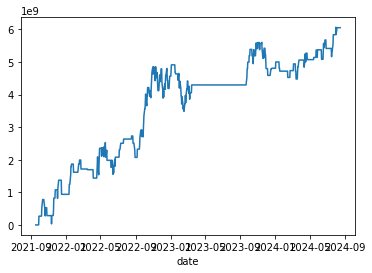

In [853]:
sharpe, max_dd = perf_metrics(prices['pnl'])
prices['pnl'].fillna(0).cumsum().plot()
print(f"Sharpe ratio: {sharpe:.2f}")
print(f"Max drawdown: {max_dd:.2f}%")

## OOS backtest

In [819]:
prices = pd.merge(vn30f1m_test, hsi_test, left_index=True, right_index=True, how = 'inner')
prices.rename(columns={'close': 'VN30F1M', 'Close': 'HSI'}, inplace=True)
prices

,VN30F1M,HSI
date,,
2021-09-17,1456.5,24920.759766
2021-09-20,1461.5,24099.140625
2021-09-21,1439.6,24221.539062
2021-09-22,1440.8,24221.539062
2021-09-23,1453.8,24510.980469
...,...,...
2024-08-12,1264.7,17111.650391
2024-08-13,1266.6,17174.060547
2024-08-14,1271.1,17113.359375


In [820]:
prices = momentum_hsi(prices)
prices['is_third_thursday'] = prices.index.map(is_third_thursday)
prices['entry_time'] = prices.apply(set_entry_time, axis=1)
prices[['exit_time', 'exit_price']] = prices.apply(lambda row: check_exit_condition(row, df), axis=1, result_type='expand')
prices

Missing entry time. Cannot retrieve entry price.
Entry Time: 2021-09-20 14:00:00, Entry Price: 1461.5
Stop Loss (Long): 1451.2694999999999, Stop Loss (Short): 1471.7305
Take Profit (Long): 1471.7305, Take Profit (Short): 1451.2694999999999
Checking short position: 2021-09-20 14:01:00, Price: 1461.8
Checking short position: 2021-09-20 14:02:00, Price: 1459.3
Checking short position: 2021-09-20 14:03:00, Price: 1458.0
Checking short position: 2021-09-20 14:04:00, Price: 1458.4
Checking short position: 2021-09-20 14:05:00, Price: 1456.8
Checking short position: 2021-09-20 14:06:00, Price: 1458.0
Checking short position: 2021-09-20 14:07:00, Price: 1457.2
Checking short position: 2021-09-20 14:08:00, Price: 1457.0
Checking short position: 2021-09-20 14:09:00, Price: 1456.7
Checking short position: 2021-09-20 14:10:00, Price: 1456.9
Checking short position: 2021-09-20 14:11:00, Price: 1456.0
Checking short position: 2021-09-20 14:12:00, Price: 1455.2
Checking short position: 2021-09-20 14:1

,VN30F1M,HSI,Pos,is_third_thursday,entry_time,exit_time,exit_price
date,,,,,,,
2021-09-17,1456.5,24920.759766,0,False,NaT,NaT,NaN
2021-09-20,1461.5,24099.140625,-1,False,2021-09-20 14:00:00,NaT,NaN
2021-09-21,1439.6,24221.539062,1,False,2021-09-21 14:00:00,NaT,NaN
2021-09-22,1440.8,24221.539062,0,False,NaT,NaT,NaN
2021-09-23,1453.8,24510.980469,1,False,2021-09-23 14:00:00,NaT,NaN
...,...,...,...,...,...,...,...
2024-08-12,1264.7,17111.650391,1,False,2024-08-12 14:00:00,NaT,NaN
2024-08-13,1266.6,17174.060547,1,False,2024-08-13 14:00:00,NaT,NaN
2024-08-14,1271.1,17113.359375,-1,False,2024-08-14 14:00:00,NaT,NaN


In [822]:
prices = pnl(prices)
prices

,VN30F1M,HSI,Pos,is_third_thursday,entry_time,exit_time,exit_price,pnl
date,,,,,,,,
2021-09-17,1456.5,24920.759766,0,False,NaT,NaT,NaN,0.0
2021-09-20,1461.5,24099.140625,-1,False,2021-09-20 14:00:00,NaT,NaN,NaN
2021-09-21,1439.6,24221.539062,1,False,2021-09-21 14:00:00,NaT,NaN,NaN
2021-09-22,1440.8,24221.539062,0,False,NaT,NaT,NaN,NaN
2021-09-23,1453.8,24510.980469,1,False,2021-09-23 14:00:00,NaT,NaN,NaN
...,...,...,...,...,...,...,...,...
2024-08-12,1264.7,17111.650391,1,False,2024-08-12 14:00:00,NaT,NaN,NaN
2024-08-13,1266.6,17174.060547,1,False,2024-08-13 14:00:00,NaT,NaN,NaN
2024-08-14,1271.1,17113.359375,-1,False,2024-08-14 14:00:00,NaT,NaN,NaN


<Axes: xlabel='date'>

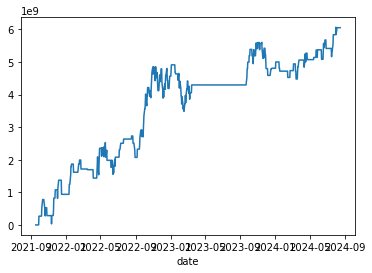

In [823]:
prices['pnl'].fillna(0).cumsum().plot()

In [824]:
sharpe, max_dd = perf_metrics(prices['pnl'])
print(f"Sharpe ratio: {sharpe}")
print(f"Max drawdown: {max_dd}")

Sharpe ratio: 1.9972169221390674
Max drawdown: 23.502653525398305
